# Download and extract data

In [53]:
INPUT='../input' # INPUT='../input/synimg' on Kaggle

In [54]:
!kaggle competitions download -p $INPUT -c synthetic-image-classification

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
synimg.zip: Skipping, found more recently modified local copy (use --force to force download)


In [55]:
!unzip -u -d $INPUT $INPUT/synimg.zip

Archive:  ../input/synimg.zip


# First look

In [56]:
!ls $INPUT/synimg

readme.txt styles.txt test       train


In [57]:
!cat $INPUT/synimg/styles.txt

Luanda
HongKong
Zurich
Singapore
Geneva
Beijing
Seoul
Sydney
Melbourne
Brisbane

# Check out training data

In [58]:
!ls $INPUT/synimg/train

Beijing   Geneva    Luanda    Seoul     Sydney    data.csv
Brisbane  HongKong  Melbourne Singapore Zurich


In [59]:
import pandas as pd
train = pd.read_csv(f'{INPUT}/synimg/train/data.csv')

In [60]:
train.head()

,id,style_name,file,filepath
0,1000000,Luanda,train-Luanda-1000000.jpg,synimg/train/Luanda/train-Luanda-1000000.jpg
1,1000001,Luanda,train-Luanda-1000001.jpg,synimg/train/Luanda/train-Luanda-1000001.jpg
2,1000002,Luanda,train-Luanda-1000002.jpg,synimg/train/Luanda/train-Luanda-1000002.jpg
3,1000003,Luanda,train-Luanda-1000003.jpg,synimg/train/Luanda/train-Luanda-1000003.jpg
4,1000004,Luanda,train-Luanda-1000004.jpg,synimg/train/Luanda/train-Luanda-1000004.jpg


In [61]:
train.shape

(100000, 4)

In [62]:
train.groupby('style_name').count()

,id,file,filepath
style_name,,,
Beijing,10000,10000,10000
Brisbane,10000,10000,10000
Geneva,10000,10000,10000
HongKong,10000,10000,10000
Luanda,10000,10000,10000
Melbourne,10000,10000,10000
Seoul,10000,10000,10000
Singapore,10000,10000,10000
Sydney,10000,10000,10000


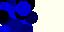

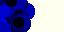

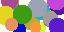

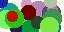

In [63]:
from IPython.display import Image
display(Image(f'{INPUT}/synimg/train/Luanda/train-Luanda-1000000.jpg'))
display(Image(f'{INPUT}/synimg/train/Luanda/train-Luanda-1000001.jpg'))
display(Image(f'{INPUT}/synimg/train/Brisbane/train-Brisbane-1090000.jpg'))
display(Image(f'{INPUT}/synimg/train/Brisbane/train-Brisbane-1090001.jpg'))

# Check out test data

In [64]:
!ls $INPUT/synimg/test

A                D                G                J
B                E                H                data_nostyle.csv
C                F                I


In [65]:
test = pd.read_csv(f'{INPUT}/synimg/test/data_nostyle.csv')

In [66]:
test.head()

,id,file,filepath
0,9000000,test-A-9000000.jpg,synimg/test/A/test-A-9000000.jpg
1,9000001,test-B-9000001.jpg,synimg/test/B/test-B-9000001.jpg
2,9000002,test-C-9000002.jpg,synimg/test/C/test-C-9000002.jpg
3,9000003,test-D-9000003.jpg,synimg/test/D/test-D-9000003.jpg
4,9000004,test-E-9000004.jpg,synimg/test/E/test-E-9000004.jpg


In [67]:
test.shape

(20000, 3)

In [68]:
!ls $INPUT/synimg/test/A | head -n1
!ls $INPUT/synimg/test/B | head -n1

test-A-9000000.jpg
test-B-9000001.jpg


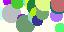

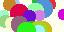

In [69]:
from IPython.display import Image
display(Image(f'{INPUT}/synimg/test/A/test-A-9000000.jpg'))
display(Image(f'{INPUT}/synimg/test/B/test-B-9000001.jpg'))

# Data processing functions

In [70]:
import numpy as np
import tensorflow as tf
import pandas as pd
import sklearn

def load_image(filepath):
    return np.asarray(tf.keras.preprocessing.image.load_img(f'{INPUT}/{filepath}')) / 255.0

def load_images(filepaths):
    return np.asarray([load_image(filepath) for filepath in filepaths])

def load_labels(labels):
    return np.asarray(pd.get_dummies(labels))

def load_data(df):
    images = load_images(df['filepath'])
    labels = load_labels(df['style_name'])
    return sklearn.model_selection.train_test_split(images, labels, test_size=0.25)

In [71]:
import unittest

class TestLoadImages(unittest.TestCase):
    def test_load_image(self):
        result = load_image('synimg/test/A/test-A-9000000.jpg')
        self.assertTrue(isinstance(result, np.ndarray))
        self.assertEqual(result.dtype, 'float64')
        self.assertEqual(result.shape, (32, 64, 3))
        self.assertTrue((result >= 0.0).all() and (result <= 1.0).all())
    def test_load_images(self):
        result = load_images(['synimg/test/A/test-A-9000000.jpg', 'synimg/test/B/test-B-9000001.jpg'])
        self.assertEqual(result.shape, (2, 32, 64, 3))

class TestLoadLabels(unittest.TestCase):
    def test_load_labels(self):
        result = load_labels(['Luanda', 'HongKong', 'Luanda', 'Zurich'])
        self.assertTrue(isinstance(result, np.ndarray))
        self.assertTrue((result == np.array([[0, 1, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1]])).all())

class TestLoadData(unittest.TestCase):
    def test_load_data(self):
        df = pd.DataFrame({
            'style_name': [
                'Luanda',
                'Luanda',
                'Brisbane',
                'Brisbane'
            ],
            'filepath': [
                'synimg/train/Luanda/train-Luanda-1000000.jpg',
                'synimg/train/Luanda/train-Luanda-1000001.jpg',
                'synimg/train/Brisbane/train-Brisbane-1090000.jpg',
                'synimg/train/Brisbane/train-Brisbane-1090001.jpg'
            ]
        })
        X_train, X_test, y_train, y_test = load_data(df)
        self.assertEqual((X_train.shape, y_train.shape), ((3, 32, 64, 3), (3, 2)))
        self.assertEqual((X_test.shape, y_test.shape), ((1, 32, 64, 3), (1, 2)))

unittest.main(argv=[''], exit=False)

....
----------------------------------------------------------------------
Ran 4 tests in 0.020s

OK


# Load data

In [72]:
train_images, test_images, train_labels, test_labels = load_data(train[:][0:1000])

# Create model

In [73]:
#!pip uninstall -y ethnicolr # needed on Kaggle due to tensorflow 1 dependency
#!pip install -q tensorflow==2.0.0-beta1

In [74]:
from tensorflow.keras import layers, models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [75]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 62, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 14, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 12, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

# Train model

In [76]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5)

Train on 750 samples
Epoch 1/5
750/750 [==============================] - 2s 2ms/sample - loss: 0.1778 - accuracy: 0.9600
Epoch 2/5
750/750 [==============================] - 1s 2ms/sample - loss: 9.5367e-07 - accuracy: 1.0000
Epoch 3/5
750/750 [==============================] - 1s 2ms/sample - loss: 9.5367e-07 - accuracy: 1.0000
Epoch 4/5
750/750 [==============================] - 1s 2ms/sample - loss: 9.5367e-07 - accuracy: 1.0000
Epoch 5/5
750/750 [==============================] - 2s 2ms/sample - loss: 9.5367e-07 - accuracy: 1.0000


# Evaluate model

In [77]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

250/250 [==============================] - 0s 706us/sample - loss: 9.5367e-07 - accuracy: 1.0000
